In [ ]:
!pip install transformers accelerate bitsandbytes

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_id = "Qwen/Qwen2-7B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",
)

In [3]:
def qwen_generate(prompt, max_tokens=512):
    text = tokenizer.apply_chat_template(
        [{"role": "user", "content": prompt}],
        tokenize=False,
        add_generation_prompt=True
    )
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    output = model.generate(
        **inputs,
        max_new_tokens=max_tokens,
        temperature=0.7,
        top_p=0.9,
    )
    return tokenizer.decode(output[0], skip_special_tokens=True)

In [4]:
import re

def clean_output(raw):
    # Xóa các ký tự lạ ngoài ASCII + tiếng Việt
    raw = re.sub(r"[^\x00-\x7FÀ-ỹ\s.,!?\"'“”‘’\-:/()]", "", raw)
    # Xóa bớt khoảng trắng dư
    raw = re.sub(r"\s+", " ", raw)
    return raw.strip()

In [5]:
def extract_json(raw):
    import json, re

    text = raw.strip()

    # 1) bỏ tất cả comment kiểu //
    text = re.sub(r"//.*", "", text)

    # 2) lấy block JSON cuối cùng
    blocks = re.findall(r"\[.*?\]", text, flags=re.DOTALL)
    if not blocks:
        print("❌ Không tìm thấy JSON\n", text)
        return None

    json_text = blocks[-1]

    # 3) bỏ chữ assistant hoặc system
    json_text = json_text.replace("assistant", "").replace("system", "")

    # 4) bỏ tất cả ký tự lạ ngoài JSON
    # (ngoại trừ [], {}, :, ", số, chữ, dấu phẩy, dấu cách)
    json_text = re.sub(r"[^\[\]\{\}:,\"0-9a-zA-ZÀ-ỹ\s]", "", json_text)

    # 5) bỏ dấu phẩy thừa cuối danh sách
    json_text = re.sub(r",\s*\]", "]", json_text)
    json_text = re.sub(r",\s*\}", "}", json_text)

    # 6) chuẩn hóa khoảng trắng
    json_text = re.sub(r"\s+", " ", json_text).strip()

    # 7) thử parse JSON
    try:
        return json.loads(json_text)
    except Exception as e:
        print("❌ JSON parse error:", e)
        print("---- JSON lỗi ----\n", json_text)
        print("------------------")
        return None

In [6]:
def paraphrase_sentiment(sentence, label_num, num):
    label_text = {0: "negative", 1: "neutral", 2: "positive"}[label_num]

    prompt = f"""
Viết lại {num} câu tiếng Việt theo cùng cảm xúc: {label_text}.
Không emoji, không thay đổi cảm xúc.

Chỉ trả JSON list dạng:
[
  {{"sentence": "...", "sentiment": {label_num}}},
  ...
]

Câu gốc: "{sentence}"
"""

    raw = qwen_generate(prompt, max_tokens=2000)
    data = extract_json(raw)
    return data if data else []

In [7]:
def generate_similar_sentiment(label_num, num):
    label_text = {0: "negative", 1: "neutral", 2: "positive"}[label_num]

    prompt = f"""
Sinh {num} câu tiếng Việt mang cảm xúc {label_text}.
Không emoji. Không giải thích.

Chỉ trả JSON list dạng:
[
  {{"sentence": "...", "sentiment": {label_num}}},
  ...
]
"""

    raw = qwen_generate(prompt, max_tokens=2000)
    data = extract_json(raw)
    return data if data else []

In [8]:
def expand_sentiment_dataset(num):
    prompt = f"""
Sinh {num} câu tiếng Việt với 3 cảm xúc: negative (0), neutral (1), positive (2).
Không emoji. Không giải thích.

Chỉ trả JSON list dạng:
[
  {{"sentence": "...", "sentiment": 0/1/2}},
  ...
]
"""

    raw = qwen_generate(prompt, max_tokens=2000)
    data = extract_json(raw)
    return data if data else []

In [9]:
seed_paraphrase = [
    ("Sản phẩm quá tệ, không đáng tiền.", 0),
    ("Dịch vụ quá chậm và không chuyên nghiệp.", 0),
    ("Chất lượng bình thường, không có gì đặc biệt.", 1),
    ("Mọi thứ đều ở mức chấp nhận được.", 1),
    ("Dịch vụ rất tốt, mình thật sự hài lòng.", 2),
    ("Sản phẩm vượt xa mong đợi của mình.", 2),
    ("Buổi học hôm nay rất thú vị.", 2),
    ("Thời tiết hôm nay khá bình thường.", 1),
    ("Trải nghiệm du lịch thật thất vọng.", 0),
    ("Bạn bè hôm nay rất tốt với mình.", 2)
]

synthetic_paraphrase = []

for text, label in seed_paraphrase:
    new_data = paraphrase_sentiment(text, label, 500) 
    synthetic_paraphrase.extend(new_data)

synthetic_similar = generate_similar_sentiment(1, 500)
synthetic_expand = expand_sentiment_dataset(500)

In [ ]:
synthetic_all = synthetic_paraphrase + synthetic_similar + synthetic_expand
print("Tổng synthetic:", len(synthetic_all))

In [ ]:
from datasets import Dataset

synthetic_ds = Dataset.from_list(synthetic_all)
synthetic_ds.to_json("synthetic_sentiment.json", force_ascii=False)

In [ ]:
!pip install evaluate

In [ ]:
from datasets import load_dataset

base = load_dataset("viethq1906/VLSP2016")
train_base = base["train"]
val_base = base["validation"]
test_base = base["test"]

print(len(train_base), len(val_base), len(test_base))

In [2]:
from datasets import load_dataset

synthetic_ds = load_dataset(
    "json",
    data_files="/kaggle/input/synthetic-data/synthetic_sentiment.json"
)["train"]

print("Số mẫu synthetic:", len(synthetic_ds))
synthetic_ds[0]

Generating train split: 0 examples [00:00, ? examples/s]

Số mẫu synthetic: 10231


{'sentence': 'Tôi không hài lòng với sản phẩm này, chất lượng thật sự kém cỏi',
 'sentiment': 0}

In [3]:
from datasets import Dataset

def clean_synthetic(ds):
    cleaned = []

    for ex in ds:
        s = ex.get("sentence", "")
        lab = ex.get("sentiment", None)

        # Bỏ câu rỗng hoặc < 4 ký tự
        if not isinstance(s, str) or len(s.strip()) < 4:
            continue

        # Label phải là INT
        try:
            lab = int(lab)
        except:
            continue

        # Label phải thuộc {0, 1, 2}
        if lab not in [0, 1, 2]:
            continue

        # Không cho câu chứa placeholder sai
        if "Tình hình chung khá" in s:   # mấy câu lỗi bạn có
            continue
        if "Mọi thứ diễn ra" in s and s.count(' ') < 4:
            continue

        # Sentence phải chứa ít nhất 4 từ
        if len(s.split()) < 4:
            continue

        cleaned.append({"sentence": s.strip(), "sentiment": lab})

    return Dataset.from_list(cleaned)


synthetic_clean = clean_synthetic(synthetic_ds)
print("Synthetic cleaned:", len(synthetic_clean))

Synthetic cleaned: 9720


In [4]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Convert the Dataset object to a pandas DataFrame for train_test_split
synthetic_clean_df = synthetic_clean.to_pandas()

train_syn_df, temp_df = train_test_split(synthetic_clean_df, test_size=0.2, random_state=42)
valid_syn_df, test_syn_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert back to Dataset objects
train_syn = Dataset.from_pandas(train_syn_df)
valid_syn = Dataset.from_pandas(valid_syn_df)
test_syn  = Dataset.from_pandas(test_syn_df)

print("Synthetic train:", len(train_syn))
print("Synthetic valid:", len(valid_syn))
print("Synthetic test :", len(test_syn))

Synthetic train: 7776
Synthetic valid: 972
Synthetic test : 972


In [5]:
from datasets import concatenate_datasets

train_merged = concatenate_datasets([base["train"], train_syn])
valid_merged = concatenate_datasets([base["validation"], valid_syn])
test_merged  = concatenate_datasets([base["test"], test_syn])

print("Merged train:", len(train_merged))
print("Merged valid:", len(valid_merged))
print("Merged test :", len(test_merged))

Merged train: 12366
Merged valid: 1482
Merged test : 2022


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

# 1. CHUẨN HÓA NHÃN: [-1, 0, 1] → [0, 1, 2]
def remap_labels(example):
    label = example["sentiment"]

    if label == -1:
        label = 0     # negative
    elif label == 0:
        label = 1     # neutral
    elif label == 1:
        label = 2     # positive

    example["sentiment"] = label
    return example

# Áp dụng remap cho cả ba tập
train_merged = train_merged.map(remap_labels)
valid_merged = valid_merged.map(remap_labels)
test_merged  = test_merged.map(remap_labels)

# 2. TOKENIZE DỮ LIỆU
def tokenize_function(batch):
    return tokenizer(
        batch["sentence"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_tokenized = train_merged.map(tokenize_function, batched=True)
valid_tokenized = valid_merged.map(tokenize_function, batched=True)
test_tokenized  = test_merged.map(tokenize_function, batched=True)

# 3. ĐỔI TÊN "sentiment" → "labels"
train_tokenized = train_tokenized.rename_column("sentiment", "labels")
valid_tokenized = valid_tokenized.rename_column("sentiment", "labels")
test_tokenized  = test_tokenized.rename_column("sentiment", "labels")

# 4. Định dạng cho PyTorch
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
valid_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
from transformers import AutoModelForSequenceClassification

base_path = "/kaggle/input/phobert-sentiment"   # thư mục model 1
model_base = AutoModelForSequenceClassification.from_pretrained(
    base_path,
    num_labels=3
)

synthetic_path = "/kaggle/input/phobert-sentiment-aug"  # thư mục model 2
model_syn = AutoModelForSequenceClassification.from_pretrained(
    synthetic_path,
    num_labels=3
)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(model, dataset):
    all_preds = []
    all_labels = []

    model.eval()

    for batch in dataset:
        input_ids = batch["input_ids"].unsqueeze(0)
        attention_mask = batch["attention_mask"].unsqueeze(0)
        labels = batch["labels"].item()

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred = outputs.logits.argmax(dim=1).item()

        all_preds.append(pred)
        all_labels.append(labels)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    return acc, f1

In [10]:
import torch

acc_base, f1_base = evaluate_model(model_base, test_tokenized)
acc_syn, f1_syn = evaluate_model(model_syn, test_tokenized)

print("=== BASE MODEL ===")
print("Accuracy:", acc_base)
print("F1-score:", f1_base)

print("\n=== SYNTHETIC MODEL ===")
print("Accuracy:", acc_syn)
print("F1-score:", f1_syn)

=== BASE MODEL ===
Accuracy: 0.6053412462908012
F1-score: 0.5633228278448882

=== SYNTHETIC MODEL ===
Accuracy: 0.863996043521266
F1-score: 0.8354629731313747


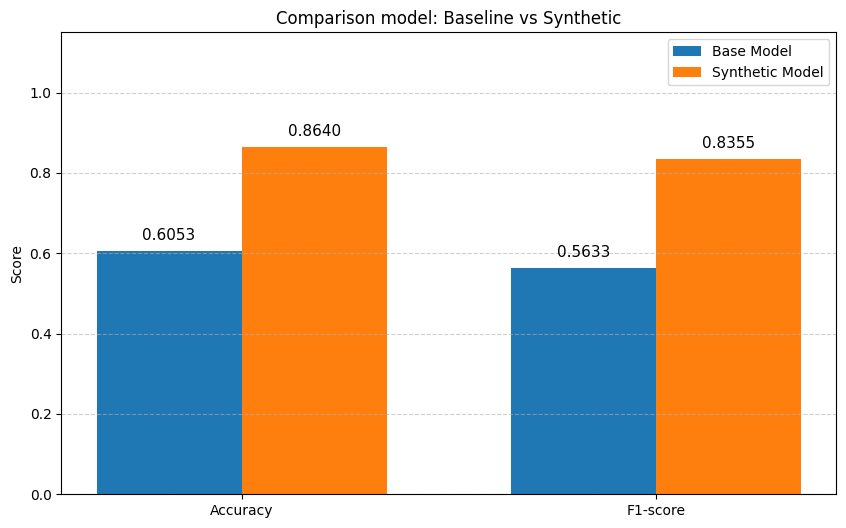

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# ==============================
# DATA
# ==============================
metrics = ["Accuracy", "F1-score"]
base_values = [acc_base, f1_base]
syn_values = [acc_syn, f1_syn]

x = np.arange(len(metrics))  
width = 0.35                

plt.figure(figsize=(10, 6))

# Base bars
bars1 = plt.bar(x - width/2, base_values, width, label="Base Model")

# Synthetic bars
bars2 = plt.bar(x + width/2, syn_values, width, label="Synthetic Model")

# ==============================
# THÊM SỐ LIỆU TRÊN ĐẦU CỘT
# ==============================
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,  
            height + 0.02,                    
            f"{height:.4f}",                  
            ha='center', va='bottom', fontsize=11
        )

add_labels(bars1)
add_labels(bars2)

# ==============================
# VẼ BIỂU ĐỒ
# ==============================
plt.ylabel("Score")
plt.title("Comparison model: Baseline vs Synthetic")
plt.xticks(x, metrics)
plt.ylim(0, 1.15)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

In [ ]:
!pip install bitsandbytes

In [ ]:
# ===========================================
# PHẦN 0 — IMPORT & CHUẨN BỊ
# ===========================================
import json
import re
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForCausalLM

# Dùng Qwen2-7B-Instruct 
llm_id = "Qwen/Qwen2-7B-Instruct"

llm_tokenizer = AutoTokenizer.from_pretrained(llm_id)
llm_model = AutoModelForCausalLM.from_pretrained(
    llm_id,
    torch_dtype=torch.float16,
    device_map="auto"
)

label2text = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# ===========================================
# PHẦN 1 — EXTRACT JSON
# ===========================================

def extract_json(text):

    # ưu tiên dạng ```json ... ```
    match = re.search(r"```json(.*?)```", text, re.DOTALL)
    if match:
        try:
            return json.loads(match.group(1).strip())
        except:
            pass
    
    # fallback JSON thuần
    match = re.search(r"{.*}", text, re.DOTALL)
    if match:
        try:
            return json.loads(match.group(0))
        except:
            return None

    return None

In [12]:
class SentimentDataset(Dataset):
    def __init__(self, hf_dataset):
        self.ds = hf_dataset.with_format("python")
    
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        item = self.ds[idx]
        return {
            "text": item["sentence"],
            "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(item["labels"], dtype=torch.long)
        }
test_dataset = SentimentDataset(test_tokenized)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Test DataLoader created:", len(test_dataset))

Test DataLoader created: 2022


In [15]:
def judge_qwen(src, pred_label, max_tokens=128):

    pred_text = label2text[pred_label]

    prompt = f"""
Bạn là hệ thống đánh giá kết quả phân loại cảm xúc tiếng Việt.

Nhiệm vụ:
1. Đọc đoạn văn bên dưới.
2. TỰ XÁC ĐỊNH cảm xúc đúng:
   - 0 = negative
   - 1 = neutral
   - 2 = positive
3. So sánh với dự đoán của mô hình (pred_label).
4. correct = 1 nếu pred_label == gpt_label, ngược lại correct = 0.

5. Chấm 2 tiêu chí theo thang 1–10:
   - correctness_score: mức độ hợp lý khi đưa ra nhãn đúng
   - confidence: mức tự tin của bạn đối với nhãn đúng

6. overall = (correctness_score + confidence) / 2

CHỈ TRẢ VỀ JSON:
{{
  "gpt_label": 0 | 1 | 2,
  "pred_label": {pred_label},
  "correctness_score": number,
  "confidence": number,
  "overall": number,
  "correct": 0 | 1
}}

ĐOẠN VĂN:
\"\"\"{src}\"\"\"

Dự đoán của mô hình:
{pred_label} ({pred_text})
"""

    inputs = llm_tokenizer(prompt, return_tensors="pt").to(llm_model.device)

    with torch.no_grad():
        output = llm_model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            do_sample=True,
            temperature=0.1,
            top_p=0.9,
        )

    text = llm_tokenizer.decode(output[0], skip_special_tokens=True)

    data = extract_json(text)
    if data:
        data["overall"] = (data["correctness_score"] + data["confidence"]) / 2

    return data, text

In [64]:
def extract_json_from_raw(raw_text):
    """
    Trích JSON cuối cùng từ raw LLM output.
    Tự sửa JSON bị thiếu '}' hoặc lỗi format đơn giản.
    """
    matches = re.findall(r"\{[\s\S]*?\}", raw_text)

    if not matches:
        return None

    # Lấy JSON cuối cùng (luôn là JSON thật)
    last = matches[-1]

    # Nếu JSON thiếu dấu } → bổ sung
    open_braces = last.count("{")
    close_braces = last.count("}")
    if open_braces > close_braces:
        last = last + "}" * (open_braces - close_braces)

    # Thử parse
    try:
        return json.loads(last)
    except:
        return None


# ======================================
# TEST KHÔNG SỬA CODE CHẤM ĐIỂM GỐC
# ======================================

test_samples = [
    ("Sản phẩm quá tệ, tôi không muốn mua lần nào nữa.", 0),
    ("Dịch vụ ổn, không tốt cũng không tệ.", 1),
    ("Món ăn giao đúng giờ nhưng hơi nguội.", 1)
]

print("\n===== KẾT QUẢ CHẤM ĐIỂM =====\n")

for i, (src, pred) in enumerate(test_samples):

    data, raw = judge_qwen(src, pred)

    # fallback nếu JSON gốc fail
    if data is None:
        data = extract_json_from_raw(raw)

    print(f"--- Case {i+1} ---")
    print(f"Text       : {src}")
    print(f"Pred label : {pred}")
    print(f"LLM Judge  : {data}\n")

print("===== KẾT THÚC =====\n")


===== KẾT QUẢ CHẤM ĐIỂM =====

--- Case 1 ---
Text       : Sản phẩm quá tệ, tôi không muốn mua lần nào nữa.
Pred label : 0
LLM Judge  : {'gpt_label': 0, 'pred_label': 0, 'correctness_score': 10, 'confidence': 9, 'overall': 9.5, 'correct': 1}

--- Case 2 ---
Text       : Dịch vụ ổn, không tốt cũng không tệ.
Pred label : 1
LLM Judge  : {'gpt_label': 1, 'pred_label': 1, 'correctness_score': 10, 'confidence': 9, 'overall': 9.5, 'correct': 1}

--- Case 3 ---
Text       : Món ăn giao đúng giờ nhưng hơi nguội.
Pred label : 1
LLM Judge  : {'gpt_label': 1, 'pred_label': 1, 'correctness_score': 10, 'confidence': 8, 'overall': 9, 'correct': 1}

===== KẾT THÚC =====



In [8]:
# ===========================================
# PHẦN 4 — TẠO FILE PREDICTION
# ===========================================

def create_prediction_file(model, dataloader, output_path, device="cuda"):
    model.to(device)
    model.eval()
    results = []

    for batch in dataloader:
        texts = batch["text"]                      # văn bản gốc
        true_labels = batch["labels"].tolist()     # nhãn thật

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            pred_labels = torch.argmax(outputs.logits, dim=-1).cpu().tolist()

        # Gom từng mẫu lại
        for src, pred, gold in zip(texts, pred_labels, true_labels):
            results.append({
                "src": src,              # văn bản gốc
                "pred_label": pred,      # mô hình dự đoán
                "true_label": gold       # nhãn thật
            })

    # Ghi ra file JSON line-by-line
    with open(output_path, "w", encoding="utf-8") as f:
        for item in results:
            f.write(json.dumps(item, ensure_ascii=False) + "\n")

    print(f"Saved prediction file: {output_path}")

In [27]:
def eval_with_qwen(input_path, output_path, limit=100):
    print(f"\n=== LLM đang chấm file: {input_path} ===")

    count = 0

    with open(input_path, "r", encoding="utf-8") as f_in, \
         open(output_path, "w", encoding="utf-8") as f_out:
        
        for line in f_in:
            if count >= limit:
                break
            
            ex = json.loads(line)

            src        = ex["src"]
            pred_label = ex["pred_label"]
            true_label = ex["true_label"]

            score, raw = judge_qwen(src, pred_label)

            if score is None:
                continue

            ex["llm_score"] = score
            ex["gpt_label"] = score["gpt_label"]
            ex["correct"]   = score["correct"]
            ex["overall"]   = score["overall"]

            f_out.write(json.dumps(ex, ensure_ascii=False) + "\n")

            count += 1
            print(f"  -> Đã chấm {count} mẫu", end="\r")

    print(f"\n=== DONE. Saved: {output_path} ===")

In [2]:
def compute_llm_metrics(path):

    correctness_scores = []
    confidences = []
    overalls = []
    corrects = []

    valid = 0
    skipped = 0

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)
            s = obj.get("llm_score", None)

            if s is None:
                skipped += 1
                continue

            try:
                cs = float(s["correctness_score"])
                cf = float(s["confidence"])
                ov = float(s["overall"])
                ct = int(s["correct"])

                correctness_scores.append(cs)
                confidences.append(cf)
                overalls.append(ov)
                corrects.append(ct)

                valid += 1

            except:
                skipped += 1

    metrics = {
        "valid_samples": valid,
        "skipped_samples": skipped,
        "correctness_score_mean": float(np.mean(correctness_scores)),
        "confidence_mean": float(np.mean(confidences)),
        "overall_mean": float(np.mean(overalls)),
        "llm_accuracy": float(np.mean(corrects))   # accuracy theo LLM
    }

    return metrics

In [29]:
# ===========================================
# PHẦN 7 — CHẠY TOÀN BỘ PIPELINE
# ===========================================

# 1) tạo file dự đoán cho baseline và synthetic
create_prediction_file(
    model_base,
    test_dataloader,
    "/kaggle/working/eval_base_for_llm.jsonl"
)

create_prediction_file(
    model_syn,
    test_dataloader,
    "/kaggle/working/eval_syn_for_llm.jsonl"
)

# 2) LLM chấm
eval_with_qwen(
    "/kaggle/working/eval_base_for_llm.jsonl",
    "/kaggle/working/eval_base_qwen_score.jsonl"
)

eval_with_qwen(
    "/kaggle/working/eval_syn_for_llm.jsonl",
    "/kaggle/working/eval_syn_qwen_score.jsonl"
)

Saved prediction file: /kaggle/working/eval_base_for_llm.jsonl
Saved prediction file: /kaggle/working/eval_syn_for_llm.jsonl

=== LLM đang chấm file: /kaggle/working/eval_base_for_llm.jsonl ===
  -> Đã chấm 100 mẫu
=== DONE. Saved: /kaggle/working/eval_base_qwen_score.jsonl ===

=== LLM đang chấm file: /kaggle/working/eval_syn_for_llm.jsonl ===
  -> Đã chấm 100 mẫu
=== DONE. Saved: /kaggle/working/eval_syn_qwen_score.jsonl ===


In [3]:
# 3) tính metric
metrics_base = compute_llm_metrics("/kaggle/input/qwen-score/eval_base_qwen_score.jsonl")
metrics_syn  = compute_llm_metrics("/kaggle/input/qwen-score/eval_syn_qwen_score.jsonl")

print("\n=== LLM-based Evaluation ===")
print("Baseline model:", metrics_base)
print("Synthetic model:", metrics_syn)


=== LLM-based Evaluation ===
Baseline model: {'valid_samples': 100, 'skipped_samples': 0, 'correctness_score_mean': 7.49, 'confidence_mean': 7.79, 'overall_mean': 7.64, 'llm_accuracy': 0.37}
Synthetic model: {'valid_samples': 100, 'skipped_samples': 0, 'correctness_score_mean': 7.76, 'confidence_mean': 8.01, 'overall_mean': 7.885, 'llm_accuracy': 0.31}


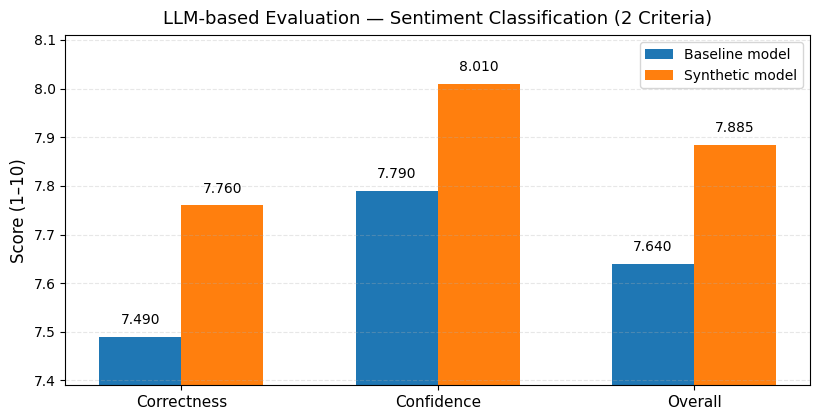

In [4]:
import matplotlib.pyplot as plt
import numpy as np

criteria = ["Correctness", "Confidence", "Overall"]

base_values = [
    metrics_base["correctness_score_mean"],
    metrics_base["confidence_mean"],
    metrics_base["overall_mean"]
]

syn_values = [
    metrics_syn["correctness_score_mean"],
    metrics_syn["confidence_mean"],
    metrics_syn["overall_mean"]
]

x = np.arange(len(criteria))
width = 0.32

plt.figure(figsize=(8.3, 4.3))

bars1 = plt.bar(x - width/2, base_values, width, label="Baseline model")
bars2 = plt.bar(x + width/2, syn_values,  width, label="Synthetic model")

plt.xticks(x, criteria, fontsize=11)
plt.ylabel("Score (1–10)", fontsize=12)

y_min = min(base_values + syn_values)
y_max = max(base_values + syn_values)
plt.ylim(y_min - 0.1, y_max + 0.1)

plt.title("LLM-based Evaluation — Sentiment Classification (2 Criteria)",
          fontsize=13, pad=8)
plt.grid(axis='y', linestyle='--', alpha=0.3)

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.02,
            f"{height:.3f}",
            ha='center',
            va='bottom',
            fontsize=10
        )

add_labels(bars1)
add_labels(bars2)

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()